# Setup

## Importation des dépendances et setup du dossier courant

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews #pyplot
!pip install -U ipykernel
!pip install keras
!pip install optuna
!pip install vggish

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 6.17.1
    Uninstalling ipykernel-6.17.1:
      Successfully uninstalled ipykernel-6.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==6.17.1, but you have ipykernel 6.29.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement vggish (from versions: none)
ERROR: No matching distribution found for vggish


In [ ]:

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy

import os
from os import listdir
from os.path import isfile, join
from google.colab import drive


# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# TensorFlow et keras
import tensorflow as tf
import tensorflow_hub as hub
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tqdm import tqdm
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import librosa
from IPython.display import Audio
from scipy.io import wavfile


# Umap
import umap.plot
from bokeh.plotting import output_notebook
from bokeh.plotting import *
from bokeh.plotting import figure, show, output_notebook

import optuna
import random as rd
import csv

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
my_local_drive='/content/gdrive/MyDrive/projet S6/covid'
%cd $my_local_drive
from AudioClassifier import AudioClassifier

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1yMAIBeFKWDklsB5kUypMOkjWXi2tB5yn/projet S6/covid


In [ ]:
PATH_CHECKPOINT = "ModelesCheckPoint"
GET_SONS_AFFICHAGE = False

## Fonctions

In [ ]:
# represente la classe si elle est exacte (1 ou 0)
def reprClasse(x):
  return "Malade" if x == 1 else "Sain"

# même chose mais si la classe est une proba (ex : 0.98 -> 1 -> chien)
def reprClasseArondi(x):
  return reprClasse(0 if x < 0.5 else 1)


# permet de visualiser n sons pour voir ce que le model a prédit
def testerAuHasardModel(model, X_test, Y_test, n):
  y_pred = model.predict(X_test, verbose=0)
  nb_tested = 0
  tested = []
  if n > len(Y_test):
    n = len(Y_test)
  while nb_tested < n:
    i = rd.randint(0,len(Y_test)-1)
    if i in tested:
      continue
    print(f"prédit : {reprClasseArondi(y_pred[i])}, réalité : {reprClasseArondi(Y_test[i][0])}")
    display(Y_test[i][1])
    nb_tested +=1


In [ ]:
# plot les courbes de plusieurs histories
def plot_curves(histories):
    plt.figure(1,figsize=(16,6))
    plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)
    for i in range(len(histories)):
    	# plot loss
    	plt.subplot(121)
    	plt.title('Cross Entropy Loss')
    	plt.plot(histories[i].history['loss'], color='blue', label='train')
    	plt.plot(histories[i].history['val_loss'], color='red', label='test')
    	plt.ylabel('loss')
    	plt.xlabel('epoch')
    	plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    	# plot accuracy
    	plt.subplot(122)
    	plt.title('Classification Accuracy')
    	plt.ylabel('accuracy')
    	plt.xlabel('epoch')
    	plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    	plt.plot(histories[i].history['val_accuracy'], color='red',
                 label='test')
    	plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
    plt.show()

# plot la courbe d'une seule history
def plot_curves_unique(history):
	plot_curves([history])

In [ ]:
def plot_curves_confusion (history,confusion_matrix):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

  # division de la fenêtre graphique en 1 ligne, 3 colonnes,
  # graphique en position 1 - loss fonction

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  # graphique en position 2 - accuracy
  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')

  class_names = ["sain", "malade"]

  # matrice de correlation
  plt.subplot(1,3,3)
  sns.heatmap(conf,annot=True,fmt="d",cmap='Blues',xticklabels=class_names, yticklabels=class_names)# label=class_names)
  # labels, title and ticks
  plt.xlabel('Predicted', fontsize=12)
  #plt.set_label_position('top')
  #plt.set_ticklabels(class_names, fontsize = 8)
  #plt.tick_top()
  plt.title("Correlation matrix")
  plt.ylabel('True', fontsize=12)
  #plt.set_ticklabels(class_names, fontsize = 8)
  plt.show()



# Prise en charge du jeu de données

## Importation du jeu de données


In [ ]:
# prise en charge du csv

dictionnaire_fichiers = {}

nb_sains = 0
nb_malades = 0
with open('raw_data/data.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for nom, classe in csvFile:
        dictionnaire_fichiers[nom] = int(classe)
        if int(classe) == 0:
          nb_sains +=1
        else:
          nb_malades += 1


In [ ]:
# importation des sons brutes

PATH = "raw_data/new_ext_5_sec/"

if GET_SONS_AFFICHAGE:

  # liste utiliser pour l'affichage
  sons_malades_raw = []
  sons_sains_raw = []
  for nom, classe in dictionnaire_fichiers.items():
    if classe == 1:
      sons_malades_raw.append(Audio(join(PATH,nom), autoplay=False))
    else:
      sons_sains_raw.append(Audio(join(PATH, nom), autoplay=False))


## Traitement des données

In [ ]:
# transformation des sons en vecteurs

# ces deux listes contiendront les mfcc
sons_malades = np.empty(nb_malades, dtype=object)
sons_sains = np.empty(nb_sains, dtype=object)

# celles la contiendront les waveform
sons_malades_wave = np.empty(nb_malades, dtype=object)
sons_sains_wave = np.empty(nb_sains, dtype=object)

i = 0
j = 0
for nom, classe in dictionnaire_fichiers.items():
  signal, sr = librosa.load(join(PATH,nom), sr=None)
  if sr != 16000:
    print(f"/!\\ sr différent de 16000 (={sr}) pour l'audio {nom}")
  if classe == 1:
    sons_malades[i] = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    sons_malades_wave[i] = signal
    i+=1
  else:
    sons_sains[j] = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    sons_sains_wave[j] = signal
    j+=1


In [ ]:
# padding des sons

desired_length = max(max([len(k[0]) for k in sons_malades]), max([len(k[0]) for k in sons_sains]))
LENGTH_SOUND = desired_length
sons_malades_padded = np.empty(len(sons_malades), dtype=object)
for i in range(len(sons_malades)):
  padded = np.pad(sons_malades[i], ((0, 0), (0, max(0, desired_length - sons_malades[i].shape[1]))), mode='constant')
  sons_malades_padded[i] = padded

sons_sains_padded = np.empty(len(sons_sains), dtype=object)
for i in range(len(sons_sains)):
  padded = np.pad(sons_sains[i], ((0, 0), (0, max(0, desired_length - sons_sains[i].shape[1]))), mode='constant')
  sons_sains_padded[i] = padded

print(LENGTH_SOUND)

31


## Création du jeu de donnée

In [ ]:
X = np.concatenate((sons_sains_padded, sons_malades_padded))
# Y contient l'animal et le son associé
if GET_SONS_AFFICHAGE:
  Y = np.array([[0, sons_sains_raw[i]] for i in range(len(sons_sains_raw))] + [[1, sons_malades_raw[i]] for i in range(len(sons_malades))])
else:
  Y = np.array([[0, 0]] * nb_sains + [[1, 1]] * nb_malades)
y = np.array([k[0] for k in Y])
DATA_SHAPE = X[0].shape
LABELS = ("Sain", "Malade")
labels = {
    0 : "Sain",
    1 : "Malade"
}


# Visualisation des données

## PCA

In [ ]:
nb_sons = len(X)
sons_reshaped = np.empty((nb_sons, LENGTH_SOUND * 13))
for i in range(nb_sons):
  sons_reshaped[i] = X[i].reshape((  LENGTH_SOUND * 13))

In [ ]:

Target_names = np.array(["Sain" if k == 0 else "Malade" for k in y])

# Utilisation de PCA
pca = PCA(n_components=2)
pca.fit(sons_reshaped)
X_pca = pca.transform(sons_reshaped)

trace0 = go.Scatter(
    x = X_pca[:,0],
    y = X_pca[:,1],
    mode = 'markers',
    text = Target_names,
    showlegend = True,
    marker = dict(
        size = 8,
        color = y,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

## TSNE

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(sons_reshaped)

traceTSNE = go.Scatter(
    x = tsne_results[:,0],
    y = tsne_results[:,1],
    text = Target_names,
    mode = 'markers',
    showlegend = True,
    marker = dict(
        size = 8,
        color = y,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceTSNE]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbour Embedding)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= False,

             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

## UMAP

<Axes: >

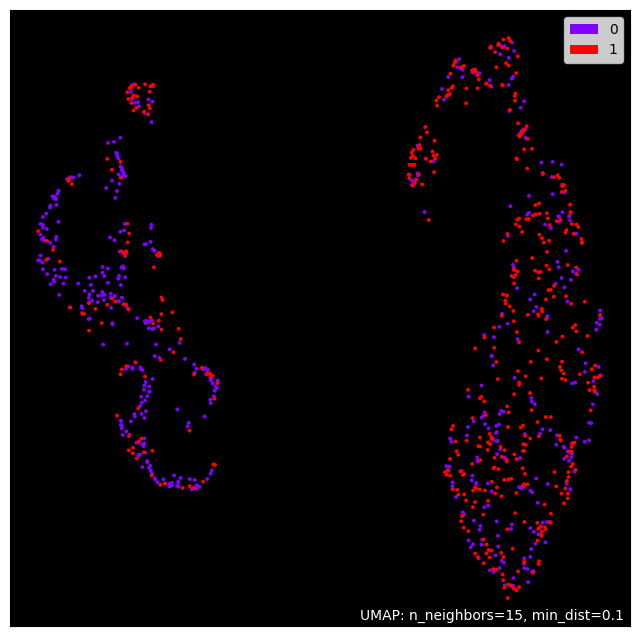

In [ ]:
mapper = umap.UMAP().fit(sons_reshaped)

# utilisation d'un dataframe pour afficher les moints
hover_data = pd.DataFrame({'index':np.arange(nb_sons),
                           'label':y})
hover_data['item'] = hover_data.label.map(labels)

# affichage de la visualisation dans le notebook
umap.plot.output_notebook()

# Utilisation de umap en interactif
#p = umap.plot.interactive(mapper, labels=y_plot,
#                          hover_data=hover_data, point_size=6)
#umap.plot.show(p)
umap.plot.points(mapper, labels=y, theme='fire')

# Test de différents modèles

## Création d'une partition train/test

In [ ]:
# Executer cette cellule si on préfère travailler sur un échantillon des données
# plutôt que sur le dataset entier.

# on préfère créer un split ici plutôt qu'a chaque modèle afin d'avoir le même
# jeu de donnée pour tous les modèles
trainsize = 0.8
testsize = 0.2

# on échantillonne pour les tests.
nb_echantillon = 800
indices = np.random.choice(len(X), size=nb_echantillon, replace=False)
X_echantillon = X[indices]
Y_echantillon = Y[indices]


X_train,X_test,Y_train,Y_test=train_test_split(X_echantillon,
                                               Y_echantillon,
                                               train_size=trainsize,
                                               test_size=testsize)
y_train = np.array([np.array(k[0]) for k in Y_train])
y_test = np.array([np.array(k[0]) for k in Y_test])
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)


In [ ]:
# on préfère créer un split ici plutôt qu'a chaque modèle afin d'avoir le même
# jeu de donnée pour tous les modèles
trainsize = 0.8
testsize = 0.2

# on échantillonne pour les tests.
#nb_echantillon = 800
#indices = np.random.choice(len(X), size=nb_echantillon, replace=False)
#X_echantillon = X[indices]
#Y_echantillon = Y[indices]


X_train,X_test,Y_train,Y_test=train_test_split(X,
                                               Y,
                                               train_size=trainsize,
                                               test_size=testsize)
y_train = np.array([np.array(k[0]) for k in Y_train])
y_test = np.array([np.array(k[0]) for k in Y_test])
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)


## Modèle baseline

### Création du modèle

Le but de ce modèle est d'avoir des résultats sur lesquels se baser afin de voir si les optimisations qu'on fera dans les prochains modèles valent le coup.
Nous avons fait le choix de mettre une couche de convolution car on souhaite, par la suite, utiliser des convolutions dans tous nos modèles

In [ ]:
# Création du modèle

baseLineClassifier = AudioClassifier(DATA_SHAPE,
                                     train_data=(X_train, y_train),
                                     test_data=(X_test, y_test),
                                     labels=LABELS,
                                     epochs = 100,
                                     earlyStop=True,
                                     batch_size=16
                                     )

baseLineClassifier.add(layers.Input(shape=(DATA_SHAPE[0], DATA_SHAPE[1], 1)))

baseLineClassifier.add(layers.Conv2D(filters = 30, kernel_size = (5,5),  activation = "relu"))
baseLineClassifier.add(MaxPooling2D(pool_size=(1, 2)))
baseLineClassifier.add(layers.Flatten())
#baseLineClassifier.add(Dense(60, activation='relu')) # a enlever pr le baseline
baseLineClassifier.add(layers.Dense(1, activation='sigmoid'))
baseLineClassifier.createModel()

### Entrainement sur le split train/test

In [ ]:
baseLineClassifier.fit(nameFileCheckpoint=f"{PATH_CHECKPOINT}/baseLine.keras")

Epoch 1/100
112/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7415 - loss: 3.4737
Epoch 1: val_loss improved from inf to 0.98080, saving model to ModelesCheckPoint/baseLine.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7436 - loss: 3.4163 - val_accuracy: 0.7691 - val_loss: 0.9808
Epoch 2/100
106/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8174 - loss: 0.6579
Epoch 2: val_loss improved from 0.98080 to 0.79965, saving model to ModelesCheckPoint/baseLine.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8173 - loss: 0.6613 - val_accuracy: 0.7930 - val_loss: 0.7996
Epoch 3/100
110/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8264 - loss: 0.5654
Epoch 3: val_loss improved from 0.79965 to 0.75045, saving model to ModelesCheckPoint/baseLine.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8274 - loss: 0.5609 - val_accuracy: 0.7734 - val_loss: 0.7504
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8801 - loss: 0.3289
Ep

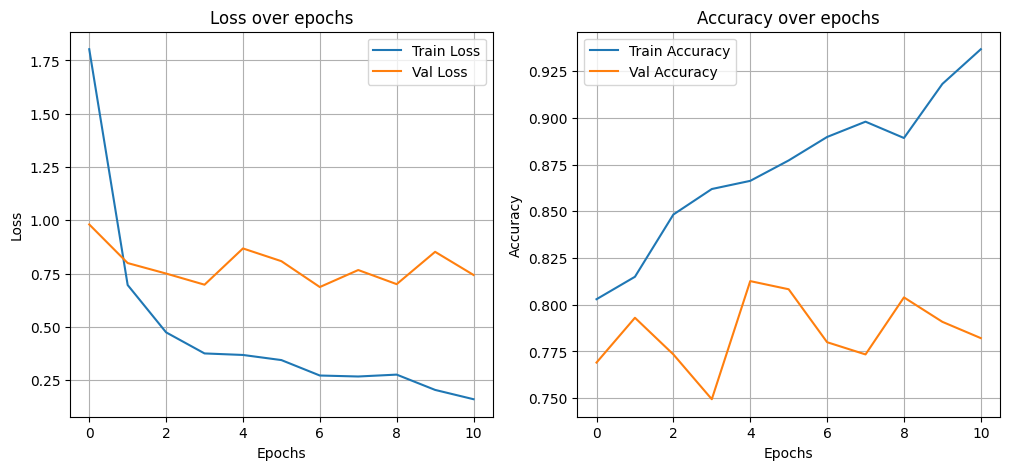

In [ ]:
baseLineClassifier.afficherHistory()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


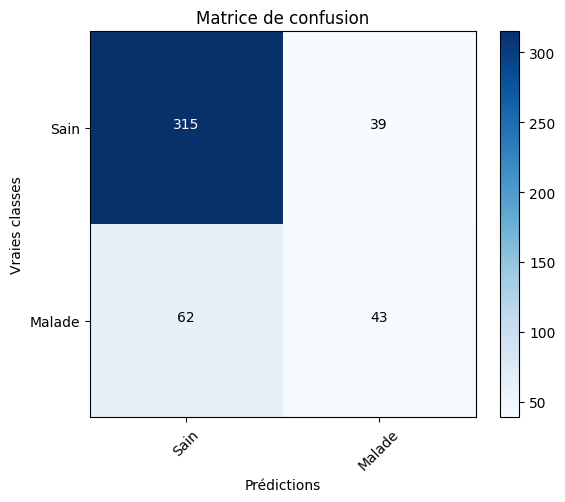

In [ ]:
baseLineClassifier.afficherMatriceConfusion()

### Cross validation

In [ ]:
# avec 5 fold
baseLineClassifier.cross_validation(nb_folds=5)


Entrainement pour le fold   1  
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8361 - loss: 0.5669 - val_accuracy: 0.8388 - val_loss: 0.4610
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8834 - loss: 0.2749 - val_accuracy: 0.8475 - val_loss: 0.5693
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8739 - loss: 0.3448 - val_accuracy: 0.8453 - val_loss: 0.5380
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8835 - loss: 0.2997 - val_accuracy: 0.8671 - val_loss: 0.4332
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9071 - loss: 0.1983 - val_accuracy: 0.8301 - val_loss: 0.4624
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9376 - loss: 0.1551 - val_accuracy: 0.8453 - val_loss: 0.4526
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9561 - loss: 0.1202 - val_accuracy: 0.7908 - val_loss: 0.5815
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy

([86.71023845672607,
  89.51964974403381,
  88.86463046073914,
  91.04803204536438,
  94.54148411750793],
 [0.43323057889938354,
  0.2619101107120514,
  0.26299598813056946,
  0.21195699274539948,
  0.15109603106975555])

In [ ]:
baseLineCrossVal5Acc = np.array([86.71023845672607,
  89.51964974403381,
  88.86463046073914,
  91.04803204536438,
  94.54148411750793])


baseLineCrossVal5Loss =[0.43323057889938354,
  0.2619101107120514,
  0.26299598813056946,
  0.21195699274539948,
  0.15109603106975555]


np.mean(baseLineCrossVal5Acc), np.std(baseLineCrossVal5Acc), np.mean(baseLineCrossVal5Loss), np.std(baseLineCrossVal5Loss)

(np.float64(90.13680696487427),
 np.float64(2.606614655072329),
 np.float64(0.2642379403114319),
 np.float64(0.09391470836672529))

Ainsi on a une accuracy de 88.48 ± 4.46 et une loss de 0.300 ± 0.156 avec 5 folds

In [ ]:
# avec 10 folds
baseLineClassifier.cross_validation(nb_folds=10)


Entrainement pour le fold   1  
Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9169 - loss: 0.2195 - val_accuracy: 0.9174 - val_loss: 0.2736
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9146 - loss: 0.1999 - val_accuracy: 0.9000 - val_loss: 0.2491
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9524 - loss: 0.1279 - val_accuracy: 0.9217 - val_loss: 0.2184
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9506 - loss: 0.1119 - val_accuracy: 0.9304 - val_loss: 0.2138
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9619 - loss: 0.1065 - val_accuracy: 0.8826 - val_loss: 0.3566
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9617 - loss: 0.0992 - val_accuracy: 0.8783 - val_loss: 0.4577
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9599 - loss: 0.1242 - val_accuracy: 0.9043 - val_loss: 0.2449
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy:

([93.04347634315491,
  95.19650936126709,
  96.94322943687439,
  95.19650936126709,
  96.50654792785645,
  96.94322943687439,
  96.94322943687439,
  97.37991094589233,
  99.12663698196411,
  96.94322943687439],
 [0.2138393521308899,
  0.11548459529876709,
  0.08211699873209,
  0.09317249059677124,
  0.06853879988193512,
  0.0671503022313118,
  0.06871161609888077,
  0.05535858869552612,
  0.028853992000222206,
  0.0697033703327179])

In [ ]:
baseLineCrossVal10Acc = np.array(
  [93.04347634315491,
  95.19650936126709,
  96.94322943687439,
  95.19650936126709,
  96.50654792785645,
  96.94322943687439,
  96.94322943687439,
  97.37991094589233,
  99.12663698196411,
  96.94322943687439]

)

np.mean(baseLineCrossVal10Acc), np.std(baseLineCrossVal10Acc)

(np.float64(96.42225086688995), np.float64(1.540928276130808))

Ainsi on a une accuracy de 95.15 ± 2.08 et une loss de 0.113 ± 0.052

##Cross val à la main

In [ ]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(self.X, self.y):

  # Definition de l'architecture du modèle
  model1 = models.Sequential()

  for layer in self.modelLayers:
    model1.add(layer)


  # Fit data sur les données
  if self.learning_rate is None:
    opt = optimizers.Adam()
  else:
    opt = optimizers.Adam(learning_rate=self.learning_rate)
  callbacks = []
  if self.earlyStop:
    callbacks.append(
        EarlyStopping(
          monitor='val_loss',
          patience=4,
          restore_best_weights=True
      )
    )


  # Compilation du modèle
  model1.compile(opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  print('\nEntrainement pour le fold  ', fold_no, ' ')
  history = model1.fit(self.X[train], self.y[train],
              batch_size=batch_size,
              epochs=self.epochs,
              validation_data=(self.X[test], self.y[test]),
              callbacks = callbacks
              )

  # Récupération des métriques (accuracy et loss)
  scores = model1.evaluate(self.X[test], self.y[test], verbose=0)
  print(f'Score pour fold {fold_no} : {model1.metrics_names[0]} = {scores[0]} - {model1.metrics_names[1]} = {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Augmentation du nombre de folds
  fold_no = fold_no + 1
self.kfoldScore = (acc_per_fold, loss_per_fold)
return acc_per_fold, loss_per_fold

## Modèle optimisé avec Optuna

### Création du Modèle et optimisation

Avec ce modèle, on va essayer d'opimiser la structure de notre modèle à l'aide d'Optuna

In [ ]:
OptunaClassifier = AudioClassifier((DATA_SHAPE[0],DATA_SHAPE[1],1),
                                     train_data=(X_train, y_train),
                                     test_data=(X_test, y_test),
                                     labels=LABELS,
                                     epochs = 100,
                                     earlyStop=True,
                                     batch_size=16
                                     )

In [ ]:
OptunaClassifier.optunaStudy(
    trials=100,
    nb_folds=2,
    hidden=(1,4),
    filters=(5,150),
    convolution_size=(2,5),
    pooling_size = (1,10),
    learning_rate = (0.001, 0.001), # valeur de base, on veut pas y toucher
    batch_size_pow2 = (4,4), # on met 16 (2**4) comme le baseline car on veut pas y toucher
    nb_conv2d = (1,3)
)

[I 2025-05-09 02:20:24,190] A new study created in memory with name: no-name-668a0c38-9696-479e-a52f-40b8dfeef35c
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

[W 2025-05-09 02:20:55,351] Trial 0 failed with parameters: {'n_hidden': 1, 'n_filters': 56, 'n_units': 35, 'n_convolution_size': 4, 'n_pooling_size': 2, 'n_conv2d': 1, 'n_learning_rate': 0.001, 'n_batch_size': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/content/gdrive/MyDrive/projet S6/covid/AudioClassifier.py", line 244, in objective
    p.join()
  File "/usr/lib/python3.11/multipro

KeyboardInterrupt: 

In [ ]:
OptunaClassifier.vizualiseStudy()

In [ ]:
OptunaClassifier.implement_best_study()
OptunaClassifier.studies[-1].best_params

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
OptunaClassifier.studies[-1].best_params

{'n_batch_size': 4,
 'n_hidden': 2,
 'n_filters': 60,
 'n_units': 90,
 'n_convolution_size': 4,
 'n_pooling_size': 7,
 'n_conv2d': 3,
 'n_learning_rate': 0.001}

In [ ]:
OptunaClassifier.model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 10, 28, 60)     │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 25, 60)      │        57,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 22, 60)      │        57,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 3, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │        64,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,535 (2.17 MB)

 Trainable params: 189,511 (740.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 379,024 (1.45 MB)

### Test du meilleur modèle avec le split train/test

In [ ]:
OptunaClassifier.fit(nameFileCheckpoint="OptunaModel.keras")

Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5385 - loss: 0.9761
Epoch 1: val_loss improved from inf to 0.72739, saving model to OptunaModel.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.5386 - loss: 0.9750 - val_accuracy: 0.4623 - val_loss: 0.7274
Epoch 2/100
195/199 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6302 - loss: 0.6720
Epoch 2: val_loss improved from 0.72739 to 0.63270, saving model to OptunaModel.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6306 - loss: 0.6716 - val_accuracy: 0.6784 - val_loss: 0.6327
Epoch 3/100
188/199 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6417 - loss: 0.6323
Epoch 3: val_loss did not improve from 0.63270
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6418 - loss: 0.6325 - val_accuracy: 0.6583 - val_loss: 0.6350
Epoch 4/100
190/199 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6671 - loss: 0.6042
Epoch 4: val_loss improved from 0.63270 to 0.61825, saving model to OptunaModel.ker

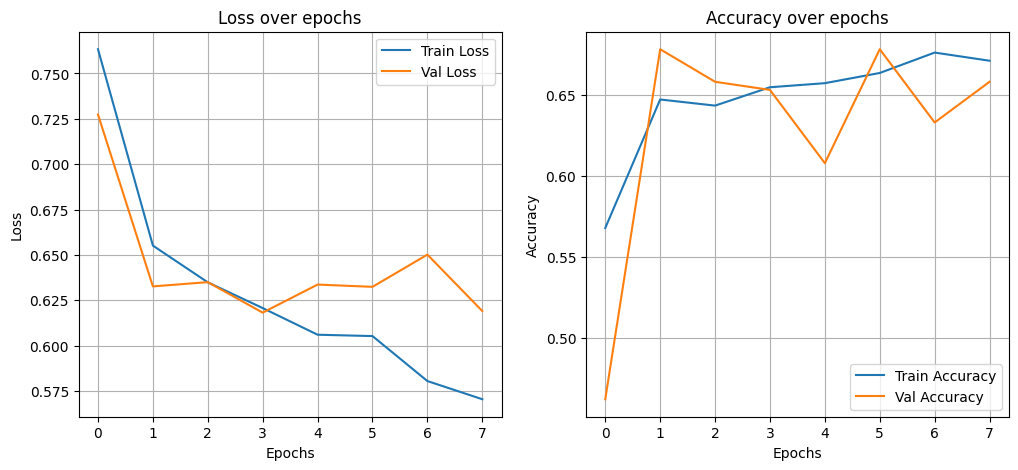

In [ ]:
OptunaClassifier.afficherHistory()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


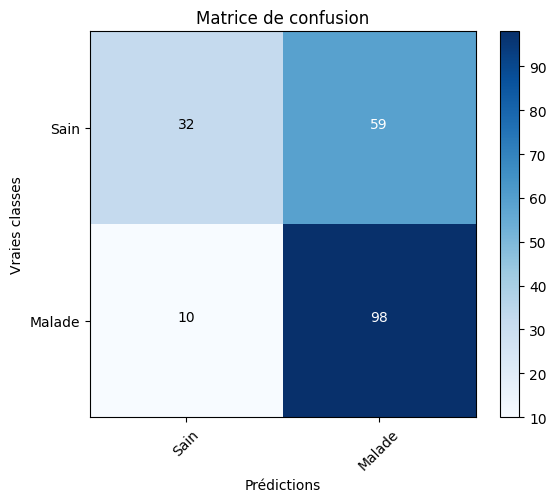

In [ ]:
OptunaClassifier.afficherMatriceConfusion()

### Cross validation du meilleur modèle

In [ ]:
OptunaClassifier.cross_validation(nb_folds=5)


Entrainement pour le fold   1  
Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8177 - loss: 0.3641 - val_accuracy: 0.8342 - val_loss: 0.3617
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8340 - loss: 0.5314 - val_accuracy: 0.8040 - val_loss: 0.4009
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8595 - loss: 0.2687 - val_accuracy: 0.8040 - val_loss: 0.4173
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8892 - loss: 0.2639 - val_accuracy: 0.8141 - val_loss: 0.3973
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9148 - loss: 0.2108 - val_accuracy: 0.8191 - val_loss: 0.4039
Score pour fold 1 : loss = 0.36170241236686707 - compile_metrics = 83.41708779335022%

Entrainement pour le fold   2  
Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7900 - loss: 0.3954 - val_accuracy: 0.8191 - val_loss: 0.5250
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8543

([83.41708779335022,
  84.92462038993835,
  85.42713522911072,
  89.39393758773804,
  86.36363744735718],
 [0.36170241236686707,
  0.3352198004722595,
  0.2774113714694977,
  0.22740896046161652,
  0.27243804931640625])

In [ ]:
OptunaClassifier.cross_validation(nb_folds=10)


Entrainement pour le fold   1  
Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9234 - loss: 0.2158 - val_accuracy: 0.9000 - val_loss: 0.2097
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9287 - loss: 0.2502 - val_accuracy: 0.8900 - val_loss: 0.2490
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9178 - loss: 0.1787 - val_accuracy: 0.8200 - val_loss: 0.4268
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8841 - loss: 0.3001 - val_accuracy: 0.8800 - val_loss: 0.3094
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9268 - loss: 0.1755 - val_accuracy: 0.8400 - val_loss: 0.3205
Score pour fold 1 : loss = 0.20972199738025665 - compile_metrics = 89.99999761581421%

Entrainement pour le fold   2  
Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9042 - loss: 0.2700 - val_accuracy: 0.9300 - val_loss: 0.1661
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9332 

([89.99999761581421,
  94.9999988079071,
  93.00000071525574,
  90.90909361839294,
  93.9393937587738,
  96.96969985961914,
  95.95959782600403,
  96.96969985961914,
  96.96969985961914,
  96.96969985961914],
 [0.20972199738025665,
  0.1378464549779892,
  0.18762226402759552,
  0.17164334654808044,
  0.20718935132026672,
  0.06981862336397171,
  0.09262464195489883,
  0.0989006757736206,
  0.08363811671733856,
  0.09551437199115753])

## Création d'un split normalisé

Nous allons d'abord normaliser les données avant d'entrainer les modeles.

In [ ]:
# normalisation du jeu de données
scaler = MinMaxScaler(feature_range=(0,1))
X_applati = np.vstack([x.reshape(-1,1) for x in X])

scaler.fit(X_applati)
X_norm = np.array([ scaler.transform(x.reshape(-1,1)).reshape(x.shape) for x in X])

In [ ]:
# on préfère créer un split ici plutôt qu'a chaque modèle afin d'avoir le même
# jeu de donnée pour tous les modèles
trainsize = 0.8
testsize = 0.2

# on échantillonne pour les tests.
X_train,X_test,Y_train,Y_test=train_test_split(X_norm,
                                               Y,
                                               train_size=trainsize,
                                               test_size=testsize)
y_train = np.array([np.array(k[0]) for k in Y_train])
y_test = np.array([np.array(k[0]) for k in Y_test])
X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)


## Modèle baseline (data normalisé)

On recommence les étapes quon a fait pour le modèle baseline mais en normalisant les données

### Création du modèle

In [ ]:
# Création du modèle

baseLineClassifierN = AudioClassifier(DATA_SHAPE,
                                     train_data=(X_train, y_train),
                                     test_data=(X_test, y_test),
                                     labels=LABELS,
                                     epochs = 100,
                                     earlyStop=True,
                                     batch_size=16
                                     )

baseLineClassifierN.add(layers.Input(shape=(DATA_SHAPE[0], DATA_SHAPE[1], 1)))

baseLineClassifierN.add(layers.Conv2D(filters = 30, kernel_size = (5,5),  activation = "relu"))
baseLineClassifierN.add(MaxPooling2D(pool_size=(1, 2)))
baseLineClassifierN.add(layers.Flatten())
#baseLineClassifierN.add(Dense(60, activation='relu')) # a enlever pr le baseline
baseLineClassifierN.add(layers.Dense(1, activation='sigmoid'))
baseLineClassifierN.createModel()

### Entrainement sur le split train/test

In [ ]:
baseLineClassifierN.fit(nameFileCheckpoint=f"{PATH_CHECKPOINT}/baseLineModeleN.keras")

Epoch 1/100
104/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7893 - loss: 0.5323
Epoch 1: val_loss improved from inf to 0.54090, saving model to ModelesCheckPoint/baseLineModeleN.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7896 - loss: 0.5304 - val_accuracy: 0.7582 - val_loss: 0.5409
Epoch 2/100
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7913 - loss: 0.4993
Epoch 2: val_loss improved from 0.54090 to 0.50454, saving model to ModelesCheckPoint/baseLineModeleN.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7913 - loss: 0.4990 - val_accuracy: 0.7582 - val_loss: 0.5045
Epoch 3/100
109/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7800 - loss: 0.4580
Epoch 3: val_loss improved from 0.50454 to 0.46562, saving model to ModelesCheckPoint/baseLineModeleN.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7806 - loss: 0.4561 - val_accuracy: 0.8083 - val_loss: 0.4656
Epoch 4/100
113/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7

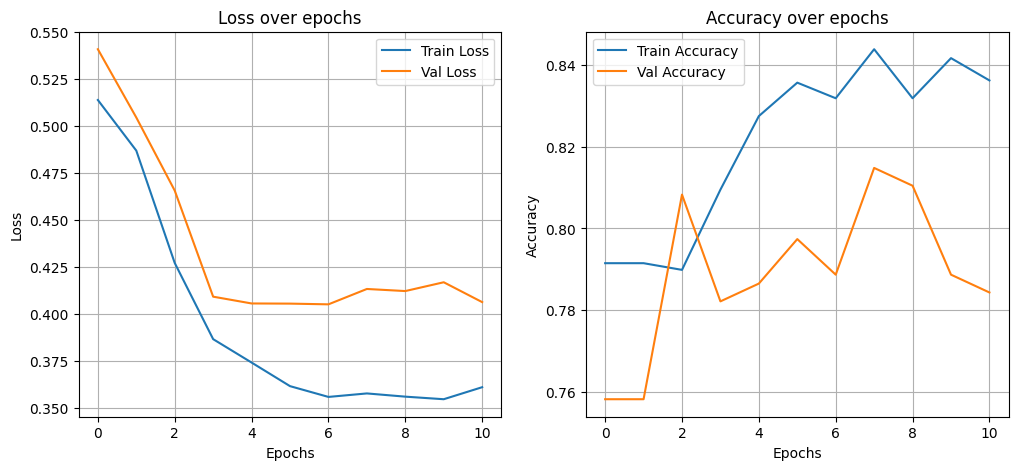

In [ ]:
baseLineClassifierN.afficherHistory()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


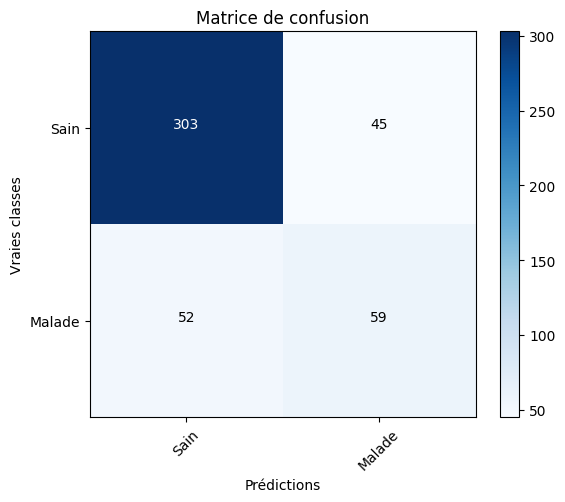

In [ ]:
baseLineClassifierN.afficherMatriceConfusion()

### Cross validation

In [ ]:
baseLineClassifierN.cross_validation(nb_folds=5)


Entrainement pour le fold   1  
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8263 - loss: 0.3840 - val_accuracy: 0.8083 - val_loss: 0.3819
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8284 - loss: 0.3715 - val_accuracy: 0.8105 - val_loss: 0.3816
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8370 - loss: 0.3555 - val_accuracy: 0.8148 - val_loss: 0.3902
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8324 - loss: 0.3714 - val_accuracy: 0.8148 - val_loss: 0.3856
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8526 - loss: 0.3528 - val_accuracy: 0.8105 - val_loss: 0.3832
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8274 - loss: 0.3802 - val_accuracy: 0.8214 - val_loss: 0.3996
Score pour fold 1 : loss = 0.3816375732421875 - compile_metrics = 81.04575276374817%

Entrainement pour le fold   2  
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8119 - 

([81.04575276374817,
  86.24454140663147,
  81.6593885421753,
  83.84279608726501,
  85.58952212333679],
 [0.3816375732421875,
  0.3163768947124481,
  0.39228489995002747,
  0.3570786416530609,
  0.3327863812446594])

In [ ]:
baseLineClassifierN.cross_validation(nb_folds=10)


Entrainement pour le fold   1  
Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8292 - loss: 0.3509 - val_accuracy: 0.8043 - val_loss: 0.4155
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8324 - loss: 0.3599 - val_accuracy: 0.8087 - val_loss: 0.4360
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8468 - loss: 0.3685 - val_accuracy: 0.7609 - val_loss: 0.4450
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8553 - loss: 0.3292 - val_accuracy: 0.7957 - val_loss: 0.4140
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8548 - loss: 0.3349 - val_accuracy: 0.8087 - val_loss: 0.4132
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8407 - loss: 0.3377 - val_accuracy: 0.7609 - val_loss: 0.4347
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8478 - loss: 0.3365 - val_accuracy: 0.8000 - val_loss: 0.4108
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

([79.56521511077881,
  84.27947759628296,
  83.40611457824707,
  87.33624219894409,
  88.20960521697998,
  87.77292370796204,
  82.53275156021118,
  81.6593885421753,
  80.34934401512146,
  88.20960521697998],
 [0.4078691601753235,
  0.38096883893013,
  0.32930058240890503,
  0.30799463391304016,
  0.24123360216617584,
  0.2853015661239624,
  0.3765454888343811,
  0.3551180064678192,
  0.42674484848976135,
  0.3216266930103302])

## Optimsation avec Optuna (data normalisé)

### Création du modèle et optimisation

In [ ]:
OptunaClassifierN = AudioClassifier((DATA_SHAPE[0],DATA_SHAPE[1],1),
                                     train_data=(X_train, y_train),
                                     test_data=(X_test, y_test),
                                     labels=LABELS,
                                     epochs = 100,
                                     earlyStop=True,
                                     batch_size=16
                                     )

NameError: name 'DATA_SHAPE' is not defined

In [ ]:
OptunaClassifierN.optunaStudy(
    trials=50,
    nb_folds=2,
    hidden=(1,4),
    filters=(5,150),
    convolution_size=(2,5), # on a des données assez petite au niveau des features ca pose pb :(
    pooling_size = (1,10),
    learning_rate = (0.001, 0.001), # valeur de base, on veut pas y toucher
    batch_size_pow2 = (4,4), # on met 16 (2**4) comme le baseline car on veut pas y toucher
    nb_conv2d = (1,3)
)

[I 2025-04-26 13:28:55,758] A new study created in memory with name: no-name-9349a450-c69a-4a35-982a-5a007f57764d
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

[I 2025-04-26 13:29:12,674] Trial 0 finished with value: 0.7848083674907684 and parameters: {'n_batch_size': 4, 'n_hidden': 4, 'n_filters': 139, 'n_units': 85, 'n_convolution_size': 4, 'n_pooling_size': 5, 'n_conv2d': 1, 'n_learning_rate': 0.001}. Best is trial 0 with value: 0.7848083674907684.
[I 2025-04-26 13:29:44,168] Trial 1 finished with value: 0.7848060727119446 and parameters: {'n_batch_size': 4, 'n_hidden': 4, 'n_filters': 63, 'n_units': 48, 'n_convolution_size': 5, 'n_pooling_size': 1, 'n_conv2d': 2, 'n_learning_rate': 0.001}. Best is trial 0 with value: 0.7848083674907684.
[I 2025-04-26 13:30:

In [ ]:
OptunaClassifierN.vizualiseStudy()

In [ ]:
OptunaClassifierN.implement_best_study()
OptunaClassifierN.studies[-1].best_params

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



{'n_batch_size': 4,
 'n_hidden': 3,
 'n_filters': 98,
 'n_units': 71,
 'n_convolution_size': 3,
 'n_pooling_size': 6,
 'n_conv2d': 1,
 'n_learning_rate': 0.001}

### Test du meilleur modèle avec le split train/test

In [ ]:
OptunaClassifierN.fit(nameFileCheckpoint=f"{PATH_CHECKPOINT}/OptunaModelNormalise.keras")

Epoch 1/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7728 - loss: 0.5277
Epoch 1: val_loss improved from inf to 0.37959, saving model to ModelesCheckPoint/OptunaModelNormalise.keras
458/458 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7729 - loss: 0.5275 - val_accuracy: 0.8214 - val_loss: 0.3796
Epoch 2/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8395 - loss: 0.3721
Epoch 2: val_loss improved from 0.37959 to 0.36588, saving model to ModelesCheckPoint/OptunaModelNormalise.keras
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8395 - loss: 0.3721 - val_accuracy: 0.8519 - val_loss: 0.3659
Epoch 3/100
449/458 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8456 - loss: 0.3641
Epoch 3: val_loss improved from 0.36588 to 0.35983, saving model to ModelesCheckPoint/OptunaModelNormalise.keras
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8455 - loss: 0.3642 - val_accuracy: 0.8388 - val_loss: 0.3598
Epoch 4/100
454/458 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

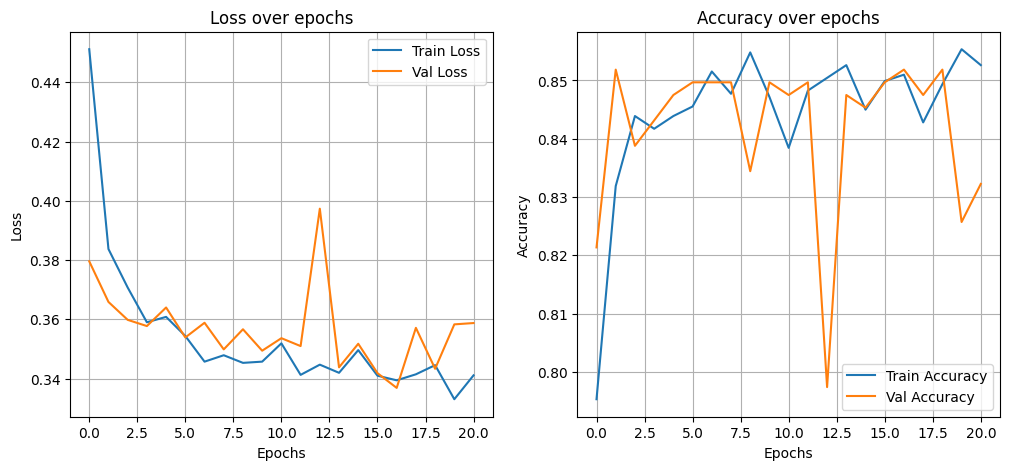

In [ ]:
OptunaClassifierN.afficherHistory()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


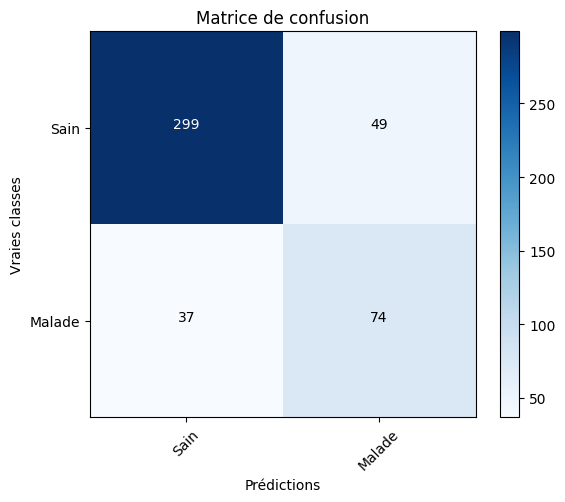

In [ ]:
baseLineClassifierN.afficherMatriceConfusion()

### Cross validation du meilleur modèle

In [ ]:
OptunaClassifierN.cross_validation(nb_folds=5)


Entrainement pour le fold   1  
Epoch 1/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7733 - loss: 0.5378 - val_accuracy: 0.8126 - val_loss: 0.4009
Epoch 2/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7985 - loss: 0.4212 - val_accuracy: 0.8453 - val_loss: 0.3022
Epoch 3/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8238 - loss: 0.4029 - val_accuracy: 0.8736 - val_loss: 0.3018
Epoch 4/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8354 - loss: 0.3915 - val_accuracy: 0.8802 - val_loss: 0.2901
Epoch 5/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8456 - loss: 0.3526 - val_accuracy: 0.8584 - val_loss: 0.3321
Epoch 6/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8498 - loss: 0.3786 - val_accuracy: 0.8649 - val_loss: 0.3158
Epoch 7/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8505 - loss: 0.3734 - val_accuracy: 0.8693 - val_loss: 0.2909
Epoch 8/100
458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy:

([88.01742792129517,
  85.15284061431885,
  82.96943306922913,
  86.68122291564941,
  86.02620363235474],
 [0.2901413142681122,
  0.3417593240737915,
  0.339838445186615,
  0.34460657835006714,
  0.3476366698741913])

In [ ]:
OptunaClassifierN.cross_validation(nb_folds=10)


Entrainement pour le fold   1  
Epoch 1/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8383 - loss: 0.3587 - val_accuracy: 0.8478 - val_loss: 0.3922
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8694 - loss: 0.3184 - val_accuracy: 0.8478 - val_loss: 0.3882
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8505 - loss: 0.3390 - val_accuracy: 0.8391 - val_loss: 0.3904
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8516 - loss: 0.3306 - val_accuracy: 0.8478 - val_loss: 0.3820
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8628 - loss: 0.3125 - val_accuracy: 0.8348 - val_loss: 0.4120
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8595 - loss: 0.3298 - val_accuracy: 0.8478 - val_loss: 0.3989
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8591 - loss: 0.3312 - val_accuracy: 0.8348 - val_loss: 0.3939
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy:

([84.78260636329651,
  83.40611457824707,
  83.84279608726501,
  88.64628672599792,
  87.33624219894409,
  85.58952212333679,
  86.02620363235474,
  86.4628791809082,
  82.96943306922913,
  85.58952212333679],
 [0.3820183575153351,
  0.3263024687767029,
  0.3649751842021942,
  0.31332460045814514,
  0.2910870611667633,
  0.3294966220855713,
  0.31582361459732056,
  0.3089410066604614,
  0.319414883852005,
  0.3307628631591797])

## Modèle de Transfert learning

## récupération de l'espace lattent de Yamnet

In [ ]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

X_latent = np.array(
    [yamnet_model(wave)[1][0] for wave in sons_sains_wave] +
    [yamnet_model(wave)[1][0] for wave in sons_malades_wave]
    )
y = np.array([0 for k in sons_sains_wave] + [1 for k in sons_malades_wave])


In [ ]:
# on préfère créer un split ici plutôt qu'a chaque modèle afin d'avoir le même
# jeu de donnée pour tous les modèles
trainsize = 0.8
testsize = 0.2

# on échantillonne pour les tests.
X_train,X_test,y_train,y_test=train_test_split(X_latent,
                                               y,
                                               train_size=trainsize,
                                               test_size=testsize)
SHAPE_LATENT = X_latent[0].shape



In [ ]:
#SHAPE_LATENT

(1, 1024)

### Modèle baseline de transfert learning

In [ ]:
baseLineYamnet = AudioClassifier(SHAPE_LATENT,
                                train_data=(X_train, y_train),
                                test_data=(X_test, y_test),
                                labels=LABELS,
                                epochs = 100,
                                earlyStop=True,
                                batch_size=16
                                )
baseLineYamnet.add(layers.Input((1,1024)))
baseLineYamnet.add(Dense(100, activation='relu'))
baseLineYamnet.add(Dense(100, activation='relu'))
baseLineYamnet.add(layers.Dense(1, activation='sigmoid'))
baseLineYamnet.createModel()



In [ ]:
baseLineYamnet.fit(nameFileCheckpoint=f"{PATH_CHECKPOINT}/baselineTransfert.keras")

Epoch 1/100
108/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.5260
Epoch 1: val_loss improved from inf to 0.42074, saving model to ModelesCheckPoint/baselineTransfert.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7722 - loss: 0.5237 - val_accuracy: 0.8148 - val_loss: 0.4207
Epoch 2/100
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7758 - loss: 0.4799
Epoch 2: val_loss improved from 0.42074 to 0.39178, saving model to ModelesCheckPoint/baselineTransfert.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7762 - loss: 0.4793 - val_accuracy: 0.8279 - val_loss: 0.3918
Epoch 3/100
106/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8108 - loss: 0.4298
Epoch 3: val_loss did not improve from 0.39178
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8113 - loss: 0.4287 - val_accuracy: 0.8388 - val_loss: 0.3931
Epoch 4/100
112/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8221 - loss: 0.4074
Epoch 4: val_loss did not improve from

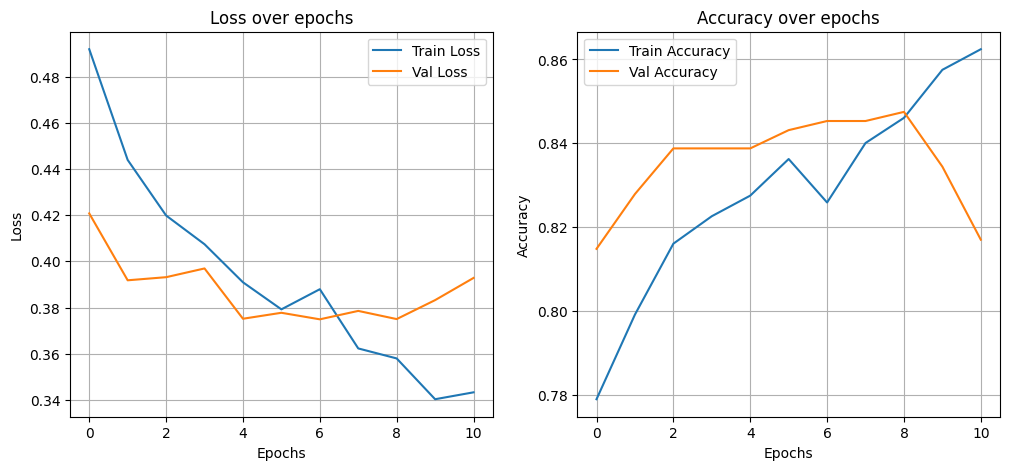

In [ ]:
baseLineYamnet.afficherHistory()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


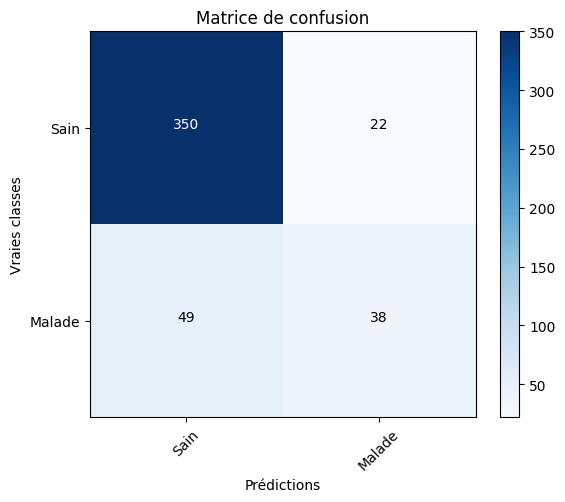

In [ ]:
baseLineYamnet.afficherMatriceConfusion()

## Optuna (à renomer)


In [ ]:
OptunaYamnetClassifier = AudioClassifier(SHAPE_LATENT,
                                train_data=(X_train, y_train),
                                test_data=(X_test, y_test),
                                labels=LABELS,
                                epochs = 100,
                                earlyStop=True,
                                batch_size=16
                                )

In [ ]:
OptunaYamnetClassifier.optunaStudy(
    trials=200,
    nb_folds=2,
    hidden=(1,4),
    pooling_size = (1,10),
    learning_rate = (0.001, 0.001), # valeur de base, on veut pas y toucher
    batch_size_pow2 = (4,4), # on met 16 (2**4) comme le baseline car on veut pas y toucher
    filters=(0,0),# pas de convolution dans ce modele
    nb_conv2d = (0,0), #..
    convolution_size=(0,0),#..
    add_flatten_layer=True
)

## Optuna Réel (à renommer)

In [ ]:
X_latent[0].shape

(1024,)

In [ ]:
X_latent[0].shape

(1024,)

In [ ]:
import multiprocessing
from multiprocessing import Process, Queue

nb_folds = 2


def train_and_eval_model(params, X_train, y_train, X_val, y_val):
  import tensorflow as tf
  from tensorflow.keras import backend as K
  from tensorflow.keras.models import Sequential
  from tensorflow.keras import layers, optimizers
  from tensorflow.keras.layers import Dense, Flatten, MaxPooling1D
  from tensorflow.keras.callbacks import EarlyStopping
  import gc

  model = Sequential()
  model.add(layers.Input(shape=(len(X_train[0]), 1)))
  for i in range(params['n_conv']):
      model.add(layers.Conv1D(
          filters=params['n_filters'],
          kernel_size=(params['n_convolution_size']),
          activation="relu"))
  model.add(MaxPooling1D(pool_size=(params['n_pooling_size'])))
  model.add(layers.Flatten())

  for i in range(params['n_hidden']):
      model.add(Dense(params['n_units'], activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  opt = optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  callbacks = []
  callbacks.append(EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True))


  model.fit(X_train, y_train,
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=0,
            epochs=100,
            callbacks=callbacks)

  score = model.evaluate(X_val, y_val, verbose=0)[1]

  del model
  K.clear_session()
  gc.collect()

  return score

def objective(trial):

  # Params sampling
  params = {
      'n_hidden': trial.suggest_int('n_hidden', 1,4),
      'n_units': trial.suggest_int('n_units', 32,128),


      'n_convolution_size': trial.suggest_int('n_convolution_size', 8, 128),
      'n_conv': trial.suggest_int('n_conv',0,3),

      'n_pooling_size': trial.suggest_int('n_pooling_size', 8,64),
      'n_filters': trial.suggest_int('n_filters', 10,150),
  }

  score = 0
  for train_idx, test_idx in kfold.split(X_latent, y):
      """q = Queue()

      def worker(q):
          s = train_and_eval_model(params, X_latent[train_idx], y[train_idx], X_latent[test_idx], y[test_idx])
          q.put(s)

      p = Process(target=worker, args=(q,))
      p.start()
      p.join()

      score += q.get()"""
      score += train_and_eval_model(params, X_latent[train_idx], y[train_idx], X_latent[test_idx], y[test_idx])

  return score / nb_folds


nb_trials = 50


kfold = KFold(n_splits=nb_folds, shuffle=True)
optuna_opt = optuna.create_study(direction="maximize")
res = optuna_opt.optimize(objective, n_trials=nb_trials, n_jobs=1)

[I 2025-05-07 19:46:43,856] A new study created in memory with name: no-name-4cc6252c-cddd-4e58-a3b6-ec40bcb0bfd7
[I 2025-05-07 19:50:40,329] Trial 0 finished with value: 0.8214714527130127 and parameters: {'n_hidden': 4, 'n_units': 112, 'n_convolution_size': 91, 'n_conv': 3, 'n_pooling_size': 13, 'n_filters': 110}. Best is trial 0 with value: 0.8214714527130127.
[I 2025-05-07 19:54:32,183] Trial 1 finished with value: 0.8136260509490967 and parameters: {'n_hidden': 2, 'n_units': 123, 'n_convolution_size': 83, 'n_conv': 3, 'n_pooling_size': 10, 'n_filters': 101}. Best is trial 0 with value: 0.8214714527130127.
[I 2025-05-07 19:57:52,308] Trial 2 finished with value: 0.8144866625467936 and parameters: {'n_hidden': 1, 'n_units': 91, 'n_convolution_size': 69, 'n_conv': 3, 'n_pooling_size': 39, 'n_filters': 106}. Best is trial 0 with value: 0.8214714527130127.
[I 2025-05-07 19:58:45,666] Trial 3 finished with value: 0.817547619342804 and parameters: {'n_hidden': 4, 'n_units': 39, 'n_convol

In [ ]:
LABELS = {0 : "sain", 1 : "malade"}
YamOptunaClassifier = AudioClassifier(X_train[0].shape,
                                train_data=(X_train, y_train),
                                test_data=(X_test, y_test),
                                labels=LABELS,
                                epochs = 100,
                                earlyStop=True,
                                batch_size=64,

                                )
YamOptunaClassifier.learning_rate = 0.01

YamOptunaClassifier.add(layers.Input(shape=(len(X_train[0]), 1)))

YamOptunaClassifier.add(layers.Conv1D(
    filters=31,
    kernel_size=(98),
    activation="relu"))
YamOptunaClassifier.add(layers.Conv1D(
    filters=31,
    kernel_size=(98),
    activation="relu"))

YamOptunaClassifier.add(layers.MaxPooling1D(pool_size=(16)))
YamOptunaClassifier.add(layers.Flatten())

YamOptunaClassifier.add(Dense(116, activation='relu'))
YamOptunaClassifier.add(Dense(116, activation='relu'))
YamOptunaClassifier.add(Dense(116, activation='relu'))
YamOptunaClassifier.add(Dense(116, activation='relu'))

YamOptunaClassifier.add(Dense(1, activation='sigmoid'))






In [ ]:
YamOptunaClassifier.fit(nameFileCheckpoint=PATH_CHECKPOINT + "/YamOptunaModel.keras")

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7019 - loss: 0.9638
Epoch 1: val_loss improved from inf to 0.52501, saving model to ModelesCheckPoint/YamOptunaModel.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.7041 - loss: 0.9541 - val_accuracy: 0.7734 - val_loss: 0.5250
Epoch 2/100
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7921 - loss: 0.4934
Epoch 2: val_loss improved from 0.52501 to 0.49953, saving model to ModelesCheckPoint/YamOptunaModel.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7917 - loss: 0.4931 - val_accuracy: 0.7734 - val_loss: 0.4995
Epoch 3/100
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7903 - loss: 0.4700
Epoch 3: val_loss improved from 0.49953 to 0.48448, saving model to ModelesCheckPoint/YamOptunaModel.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7895 - loss: 0.4707 - val_accuracy: 0.7734 - val_loss: 0.4845
Epoch 4/100
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7826 - los

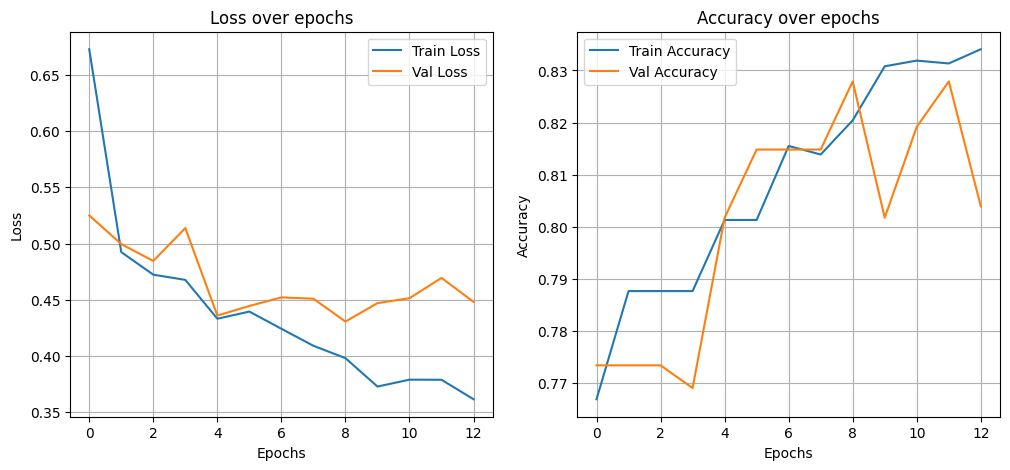

In [ ]:
YamOptunaClassifier.afficherHistory()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


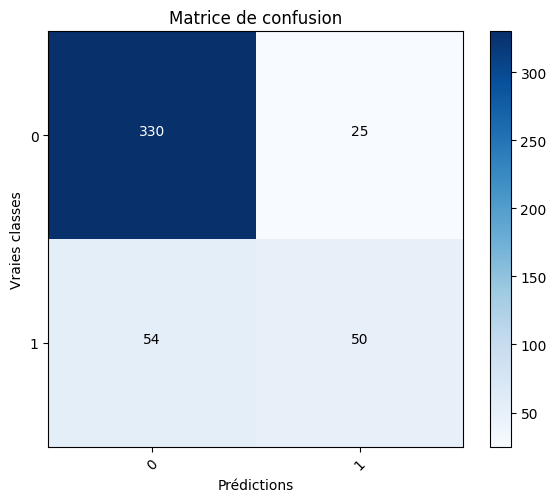

In [ ]:
YamOptunaClassifier.afficherMatriceConfusion()

In [ ]:
YamOptunaClassifier.cross_validation(nb_folds=10)


Entrainement pour le fold   1  
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.8021 - loss: 0.4410 - val_accuracy: 0.8696 - val_loss: 0.3592
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8028 - loss: 0.4237 - val_accuracy: 0.8696 - val_loss: 0.3673
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8292 - loss: 0.3976 - val_accuracy: 0.8696 - val_loss: 0.3477
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8251 - loss: 0.3922 - val_accuracy: 0.8478 - val_loss: 0.3576
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8241 - loss: 0.3880 - val_accuracy: 0.8609 - val_loss: 0.3596
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8348 - loss: 0.3789 - val_accuracy: 0.8565 - val_loss: 0.3794
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8492 - loss: 0.3512 - val_accuracy: 0.8696 - val_loss: 0.3724
Score pour fold 1 : loss = 0.34773412346839905 - compile_metrics = 86.

([86.95651888847351,
  79.91266250610352,
  86.89956068992615,
  82.53275156021118,
  85.58952212333679,
  88.20960521697998,
  86.02620363235474,
  89.08296823501587,
  87.33624219894409,
  86.4628791809082],
 [0.34773412346839905,
  0.4367184638977051,
  0.3016408085823059,
  0.3845786452293396,
  0.3380860686302185,
  0.33894509077072144,
  0.3024706244468689,
  0.28178295493125916,
  0.3057795464992523,
  0.29897958040237427])

In [ ]:
acc_optuna_yamnet = [81.4814805984497,
  80.7860255241394,
  80.13100624084473,
  83.40611457824707,
  88.20960521697998]



np.mean(acc_optuna_yamnet), np.std(acc_optuna_yamnet)#, np.mean(baseLineCrossVal5Loss), np.std(baseLineCrossVal5Loss)



(np.float64(82.80284643173218), np.float64(2.9171656539444215))

In [ ]:
YamOptunaClassifier.fit()

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8663 - loss: 0.3179 - val_accuracy: 0.8366 - val_loss: 0.3722
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8741 - loss: 0.3084 - val_accuracy: 0.8257 - val_loss: 0.3766
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8860 - loss: 0.2889 - val_accuracy: 0.8388 - val_loss: 0.3621
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8959 - loss: 0.2670 - val_accuracy: 0.8519 - val_loss: 0.3542
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8953 - loss: 0.2703 - val_accuracy: 0.8388 - val_loss: 0.3913
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8949 - loss: 0.2545 - val_accuracy: 0.8148 - val_loss: 0.4441
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9030 - loss: 0.2499 - val_accuracy: 0.8453 - val_loss: 0.3837
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8971 - loss: 0.2696 - val_accuracy: 0.8475 - v

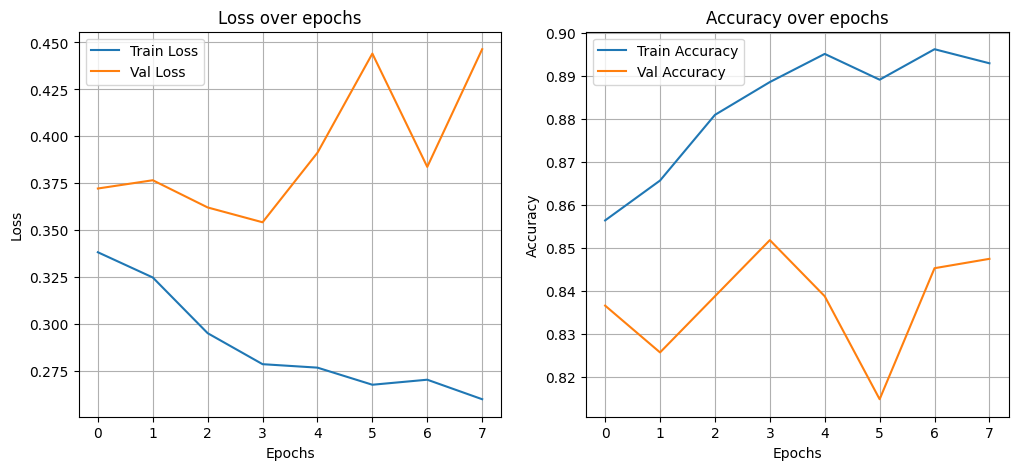

In [ ]:
YamOptunaClassifier.afficherHistory()

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step


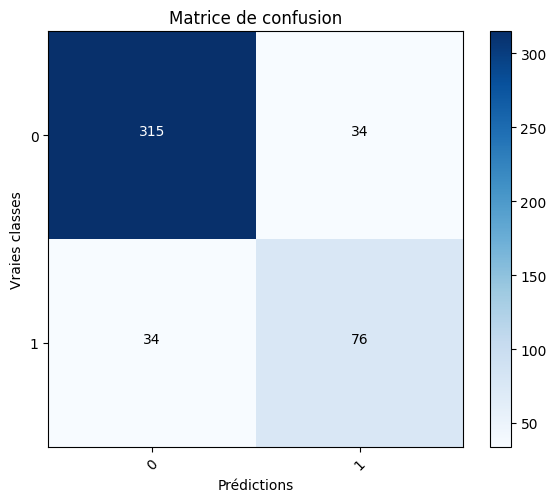

In [ ]:

YamOptunaClassifier.afficherMatriceConfusion()

## Optuna sans conv

In [ ]:
import multiprocessing
from multiprocessing import Process, Queue

nb_folds = 2


def train_and_eval_model(params, X_train, y_train, X_val, y_val):


  model = Sequential()
  model.add(layers.Input(shape=(len(X_train[0]), 1)))
  #model.add(MaxPooling1D(pool_size=(params['n_pooling_size'])))
  model.add(layers.Flatten())

  for i in range(params['n_hidden']):
      model.add(Dense(params['n_units'], activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  opt = optimizers.Adam(learning_rate=0.1**(params["n_learning_rate"]))
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  callbacks = []
  callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))


  model.fit(X_train, y_train,
            batch_size=2**params["n_batch_size"],
            validation_data=(X_val, y_val),
            verbose=0,
            epochs=100,
            callbacks=callbacks)

  score = model.evaluate(X_val, y_val, verbose=0)[1]

  del model
  #K.clear_session()
  #gc.collect()

  return score

def objective(trial):

  # Params sampling
  params = {
      'n_hidden': trial.suggest_int('n_hidden', 1,4),
      'n_units': trial.suggest_int('n_units', 32,128),


      'n_learning_rate': trial.suggest_int('n_learning_rate', 1,5),
      'n_batch_size': trial.suggest_int("n_batch_size", 3, 8),

  }

  score = 0
  for train_idx, test_idx in kfold.split(X_latent, y):
      score += train_and_eval_model(params, X_latent[train_idx], y[train_idx], X_latent[test_idx], y[test_idx])

  return score / nb_folds


nb_trials = 100


kfold = KFold(n_splits=nb_folds, shuffle=True)
optuna_opt = optuna.create_study(direction="maximize")
res = optuna_opt.optimize(objective, n_trials=nb_trials, n_jobs=1)

[I 2025-05-08 05:02:14,328] A new study created in memory with name: no-name-0b37de10-6b5f-4659-b0a4-0de1c17d5a8d
[I 2025-05-08 05:02:34,978] Trial 0 finished with value: 0.7848102748394012 and parameters: {'n_hidden': 4, 'n_units': 108, 'n_learning_rate': 1, 'n_batch_size': 3}. Best is trial 0 with value: 0.7848102748394012.
[I 2025-05-08 05:02:46,760] Trial 1 finished with value: 0.7944073379039764 and parameters: {'n_hidden': 1, 'n_units': 65, 'n_learning_rate': 2, 'n_batch_size': 4}. Best is trial 1 with value: 0.7944073379039764.
[I 2025-05-08 05:03:02,468] Trial 2 finished with value: 0.7848121821880341 and parameters: {'n_hidden': 2, 'n_units': 102, 'n_learning_rate': 1, 'n_batch_size': 4}. Best is trial 1 with value: 0.7944073379039764.
[I 2025-05-08 05:03:17,148] Trial 3 finished with value: 0.8110012412071228 and parameters: {'n_hidden': 3, 'n_units': 95, 'n_learning_rate': 3, 'n_batch_size': 6}. Best is trial 3 with value: 0.8110012412071228.
[I 2025-05-08 05:03:41,921] Tria

In [ ]:
#[I 2025-05-08 05:19:33,876] Trial 42 finished with value: 0.8249632120132446 and parameters: {'n_hidden': 2, 'n_units': 68, 'n_learning_rate': 3, 'n_batch_size': 6}. Best is trial 42 with value: 0.8249632120132446.


LABELS = {0 : "sain", 1 : "malade"}
YamOptunaClassifier = AudioClassifier(X_train[0].shape,
                                train_data=(X_train, y_train),
                                test_data=(X_test, y_test),
                                labels=LABELS,
                                epochs = 100,
                                earlyStop=True,
                                batch_size=64,

                                )
YamOptunaClassifier.learning_rate = 0.001

YamOptunaClassifier.add(layers.Input(shape=(len(X_train[0]), 1)))


YamOptunaClassifier.add(layers.MaxPooling1D(pool_size=(16)))
YamOptunaClassifier.add(layers.Flatten())

YamOptunaClassifier.add(Dense(68, activation='relu'))
YamOptunaClassifier.add(Dense(68, activation='relu'))

YamOptunaClassifier.add(Dense(1, activation='sigmoid'))






In [ ]:
YamOptunaClassifier.fit()

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6757 - loss: 0.6311 - val_accuracy: 0.7734 - val_loss: 0.5098
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7959 - loss: 0.4709 - val_accuracy: 0.7712 - val_loss: 0.4931
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7906 - loss: 0.4676 - val_accuracy: 0.7669 - val_loss: 0.4731
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7911 - loss: 0.4543 - val_accuracy: 0.7756 - val_loss: 0.4617
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7973 - loss: 0.4391 - val_accuracy: 0.7865 - val_loss: 0.4525
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8079 - loss: 0.4306 - val_accuracy: 0.7930 - val_loss: 0.4425
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8225 - loss: 0.4110 - val_accuracy: 0.7691 - val_loss: 0.4738
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8070 - loss: 0.4095 - val_accuracy: 0.7821 - 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


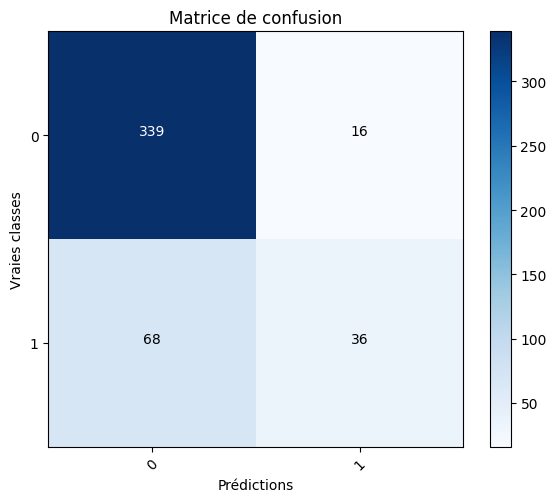

In [ ]:
YamOptunaClassifier.afficherMatriceConfusion()

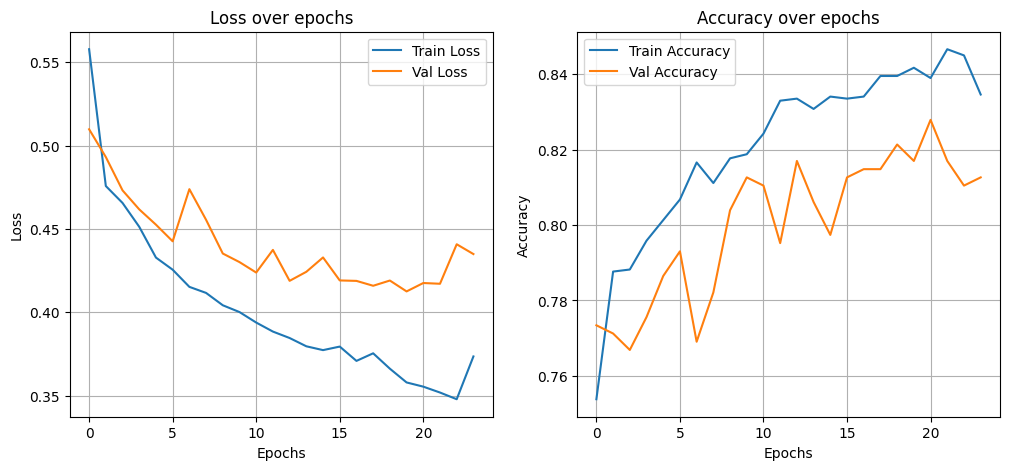

In [ ]:
YamOptunaClassifier.afficherHistory()

In [ ]:
YamOptunaClassifier.cross_validation(nb_folds=5)


Entrainement pour le fold   1  
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8371 - loss: 0.3975 - val_accuracy: 0.8301 - val_loss: 0.3498
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8253 - loss: 0.3860 - val_accuracy: 0.8388 - val_loss: 0.3408
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8409 - loss: 0.3760 - val_accuracy: 0.8301 - val_loss: 0.3534
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8395 - loss: 0.3656 - val_accuracy: 0.8366 - val_loss: 0.3461
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8348 - loss: 0.3581 - val_accuracy: 0.8366 - val_loss: 0.3473
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8320 - loss: 0.3706 - val_accuracy: 0.8497 - val_loss: 0.3415
Score pour fold 1 : loss = 0.3408006429672241 - compile_metrics = 83.87799859046936%

Entrainement pour le fold   2  
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8275 - loss: 0.3808 

([83.87799859046936,
  84.7161591053009,
  85.15284061431885,
  85.15284061431885,
  85.15284061431885],
 [0.3408006429672241,
  0.3721518814563751,
  0.3471680283546448,
  0.349459171295166,
  0.3345203697681427])

In [ ]:
YamOptunaClassifier.cross_validation(nb_folds=12)


Entrainement pour le fold   1  
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8512 - loss: 0.3397 - val_accuracy: 0.8377 - val_loss: 0.4082
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8575 - loss: 0.3406 - val_accuracy: 0.8168 - val_loss: 0.4452
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8624 - loss: 0.3271 - val_accuracy: 0.8325 - val_loss: 0.4141
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8638 - loss: 0.3183 - val_accuracy: 0.8325 - val_loss: 0.4261
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8742 - loss: 0.3170 - val_accuracy: 0.8429 - val_loss: 0.4250
Score pour fold 1 : loss = 0.40822353959083557 - compile_metrics = 83.76963138580322%

Entrainement pour le fold   2  
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8617 - loss: 0.3228 - val_accuracy: 0.8482 - val_loss: 0.3379
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8698 - loss: 0.3150

([83.76963138580322,
  84.29319262504578,
  87.95811533927917,
  86.38743162155151,
  85.34031510353088,
  86.38743162155151,
  92.14659929275513,
  87.95811533927917,
  89.00523781776428,
  89.00523781776428,
  87.43455410003662,
  88.42105269432068],
 [0.40822353959083557,
  0.3347475230693817,
  0.31917819380760193,
  0.3086455464363098,
  0.33280760049819946,
  0.32178521156311035,
  0.24987199902534485,
  0.29392382502555847,
  0.27210941910743713,
  0.2646384835243225,
  0.27643969655036926,
  0.25466957688331604])

((), (459, 1024))

##Yamnet avec classe weight sans conv


In [ ]:
#[I 2025-05-08 05:19:33,876] Trial 42 finished with value: 0.8249632120132446 and parameters: {'n_hidden': 2, 'n_units': 68, 'n_learning_rate': 3, 'n_batch_size': 6}. Best is trial 42 with value: 0.8249632120132446.
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

model = Sequential()

model.add(layers.Input(shape=(len(X_train[0]),1)))

#model.add(layers.MaxPooling1D(pool_size=(16)))
model.add(layers.Flatten())
model.add(layers.Dense(68, activation="relu"))
model.add(layers.Dense(68, activation="relu"))
model.add(layers.Dense(1, activation = "sigmoid"))

opt = optimizers.Adam(learning_rate=0.001)

model.compile(
      optimizer=opt,
      loss='binary_crossentropy',
      metrics=[
        'accuracy'
      ],
    )


callbacks = []

callbacks.append(EarlyStopping(patience=3, restore_best_weights=True))



history = model.fit(
      X_train, y_train,
      batch_size=64,
      validation_data=(X_test, y_test),
      verbose=1,
      callbacks=callbacks,
      epochs=100,
      class_weight={0: weights[0], 1: weights[1]}
)




Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6477 - loss: 0.6667 - val_accuracy: 0.7647 - val_loss: 0.5622
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7003 - loss: 0.5970 - val_accuracy: 0.7669 - val_loss: 0.5456
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6623 - loss: 0.5972 - val_accuracy: 0.7495 - val_loss: 0.5413
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7412 - loss: 0.5642 - val_accuracy: 0.8192 - val_loss: 0.4744
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7580 - loss: 0.5456 - val_accuracy: 0.7625 - val_loss: 0.5459
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7404 - loss: 0.5121 - val_accuracy: 0.8235 - val_loss: 0.4711
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7941 - loss: 0.4994 - val_accuracy: 0.7887 - val_loss: 0.4899
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7800 - loss: 0.5191 - val_accuracy: 0.825

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


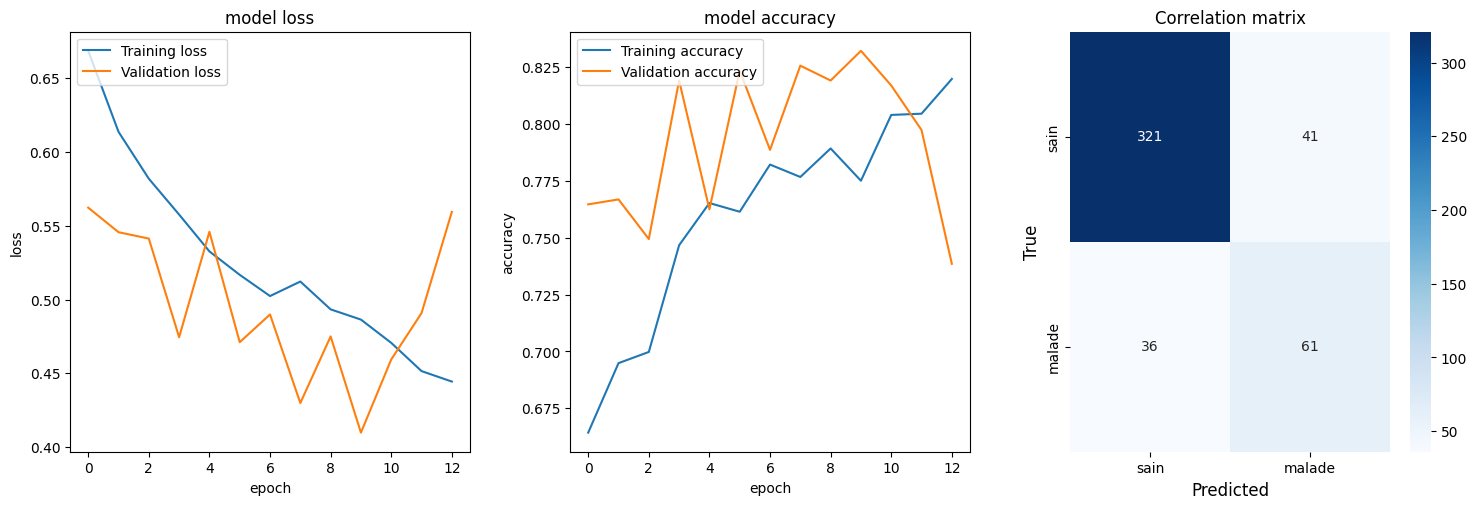

In [ ]:
y_pred = [0 if k < 0.5 else 1 for k in model.predict(X_test)]
conf = confusion_matrix(y_pred=y_pred, y_true=y_test)
plot_curves_confusion(confusion_matrix=conf, history = history)


##Yamnet avec classe weigt et conv

In [ ]:
#[I 2025-05-07 21:28:23,336] Trial 49 finished with value: 0.8332652846972147 and parameters: {'n_hidden': 4, 'n_units': 116, 'n_convolution_size': 98, 'n_conv': 2, 'n_pooling_size': 16, 'n_filters': 31}. Best is trial 49 with value: 0.8332652846972147.
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

model = Sequential()

model.add(layers.Input(shape=(len(X_train[0]),1)))

model.add(layers.Conv1D(kernel_size=(98), filters=31))
model.add(layers.Conv1D(kernel_size=(98), filters=31))
model.add(layers.MaxPooling1D(pool_size=(16)))
model.add(layers.Flatten())
model.add(layers.Dense(116, activation="relu"))
model.add(layers.Dense(116, activation="relu"))
model.add(layers.Dense(116, activation="relu"))
model.add(layers.Dense(116, activation="relu"))
model.add(layers.Dense(1, activation = "sigmoid"))

opt = optimizers.Adam(learning_rate=0.001)

model.compile(
      optimizer=opt,
      loss='binary_crossentropy',
      metrics=[
        'accuracy'
      ],
    )


callbacks = []

callbacks.append(EarlyStopping(patience=3, restore_best_weights=True))



history = model.fit(
      X_train, y_train,
      batch_size=64,
      validation_data=(X_test, y_test),
      verbose=1,
      callbacks=callbacks,
      epochs=100,
      class_weight={0: weights[0], 1: weights[1]}
)




Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5991 - loss: 0.6872 - val_accuracy: 0.8039 - val_loss: 0.5976
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6837 - loss: 0.6471 - val_accuracy: 0.7778 - val_loss: 0.5194
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6893 - loss: 0.5756 - val_accuracy: 0.8083 - val_loss: 0.5004
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7586 - loss: 0.5613 - val_accuracy: 0.7952 - val_loss: 0.5150
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7831 - loss: 0.5108 - val_accuracy: 0.8453 - val_loss: 0.4065
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7595 - loss: 0.5255 - val_accuracy: 0.8301 - val_loss: 0.4513
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7912 - loss: 0.4973 - val_accuracy: 0.8344 - val_loss: 0.4175
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8109 - loss: 0.4684 - val_accuracy: 0.6841 - v

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step


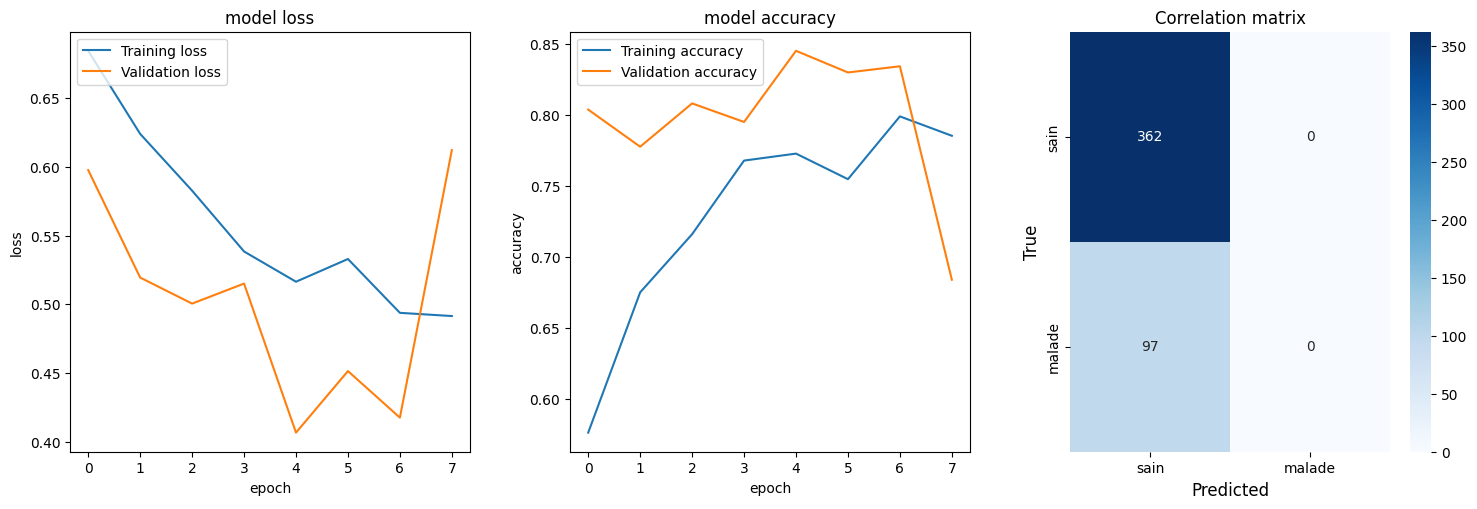

In [ ]:
y_pred = [0 if k < 0.5 else 1 for k in model.predict(X_test)]
conf = confusion_matrix(y_pred=y_pred, y_true=y_test)
plot_curves_confusion(confusion_matrix=conf, history = history)
